In [214]:
import numpy as np
import pandas as pd
import re
import pickle
import lightgbm as lgb
from sklearn.model_selection import cross_validate, KFold
import matplotlib.pyplot as plt
from collections import Counter

In [211]:
import warnings
warnings.filterwarnings('ignore')

In [212]:
plt.rcParams['font.family'] = 'IPAGothic'

In [213]:
train = pd.read_csv("../data/train_Youto_sentence_and_heading.csv")

In [268]:
with open("../dump/noun_list.pickle", 'br') as f:
    noun_list = pickle.load(f)

In [476]:
with open("../dump/clue_words.pickle", 'br') as f:
    clue_word_by_BS = pickle.load(f)

In [414]:
clue_word = pd.read_csv("../data/clue_word_of_Sahen-setsuzoku_with_beta=0.1.csv", names=['clue_word']).clue_word.values

feature_word_dict = {}

# 文中に各手がかり語が含まれているどうか
#for word in np.append(clue_word, ['用途', '用い', '使わ']):
for word in clue_word2:
    feature_word_dict[word] = train.sentence.str.contains(fr'{word}').tolist()

In [336]:
# サブタイトル名をもとにカテゴリ変数を作成する

train = train.assign(heading_cat = np.nan)

cat1 = r'NO_SUBTITLE'
train.loc[train.heading.str.contains(cat1), 'heading_cat'] = 0

cat2 = r'|'.join(np.append(clue_word, '用途'))
train.loc[train.heading.str.contains(cat2), 'heading_cat'] = 1

train.loc[train.heading_cat.isna(), 'heading_cat'] = 2

In [434]:
# 文中にカテゴリ名が含まれているどうか

#category_list = '|'.join(pd.read_csv("../data/category_in_train_data.csv").category.values)
#category_list = '|'.join(pd.read_csv("../data/category_list.csv").category.values)
category_list = '|'.join(pd.read_csv("../data/category_in_noun_list.csv").category.values)
is_contain_cat = train.sentence.str.contains(category_list).tolist()

In [459]:
#train_X = pd.DataFrame(feature_word_dict)
#train_X = pd.DataFrame(feature_word_dict).assign(heading_cat = train.heading_cat)
train_X = \
pd.DataFrame(feature_word_dict).assign(
    heading_cat = train.heading_cat
    , is_contain_cat = is_contain_cat
    , is_clue_word = train.sentence.str.contains("|".join(clue_word).replace(")", "\)").replace("(", "\("))
    #, is_negative = train.sentence.str.contains("副作用|禁止|禁忌|危険|毒性")
)
train_X.heading_cat = train_X.heading_cat.astype('category') 
train_y = train.label.tolist()

In [460]:
model = lgb.LGBMClassifier(is_unbalance=False)

scores = cross_validate(model, train_X, train_y, scoring=['f1', 'precision', 'recall'], cv=5)

print("f1: ", scores['test_f1'].mean())
print("precision: ", scores['test_precision'].mean())
print("recall: ", scores['test_recall'].mean())

f1:  0.5875262198001286
precision:  0.7071609827363288
recall:  0.5039144974100059


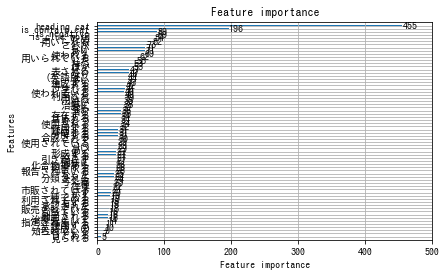

In [451]:
model.fit(train_X, train_y)
lgb.plot_importance(model)

In [452]:
predict = model.predict(train_X)

In [453]:
TP_index = np.where((predict == train_y) & (predict == 1))[0]
TN_index = np.where((predict == train_y) & (predict == 0))[0]
FP_index = np.where((predict != train_y) & (predict == 1))[0]
FN_index = np.where((predict != train_y) & (predict == 0))[0]

In [454]:
print("TP: ", len(TP_index))
print("TN: ", len(TN_index))
print("FP: ", len(FP_index))
print("FN: ", len(FN_index))

TP:  829
TN:  4921
FP:  236
FN:  685


In [475]:
print(train.loc[FP_index, 'sentence'].values)

['構造的には重篤な造血機能障害を生ずるアミノピリンと同系統であるが、発癌作用のあるニトロソアミンにはならず、アミノピリンの代替薬として広く使用されている。'
 '通常フマル酸塩が用いられる。' 'オシメルチニブは第一選択治療薬としての早期臨床試験の段階にある。'
 'なお、カフェインの排除能力の低いヒトの胎児では、CYP1A2による酸化とは全く別に、メチル化するという代謝経路も利用されることが知られている。'
 'そのため、限度を超えた摂取や投薬中・妊娠中のカフェインの摂取に関しては医者の指示を仰いだ方がよい。'
 '診断名としては「カフェイン誘発性睡眠障害、不眠症型、中毒中の発症」のように記入する。'
 'カフェインはエストロゲンの分泌を亢進させる働きがあるため、乳腺症などのエストロゲンによる症状がある場合、カフェインの摂取を控えることで症状が改善する場合がある。'
 '増殖中のCLL細胞をイブルチニブで処理すると、ブルトン型チロシンキナーゼ（BTK）のリン酸化が阻害され、BTKで活性化されるERK1/2、PI3K、NF-κB等の生存経路（シグナル量）が低減する。'
 '初回の抗レトロウイルス治療の場合は、ネビラピンを含む3剤併用療法で効果的にウイルス量（英語版）を低下させる事が出来る。'
 'レーザアブレーション(PLD)法 PLD法はPVD(物理気相蒸着)法の一種で、装置自体は他のPVD薄膜作製技術と比べ、最も単純で薄膜作製も容易で堆積させた薄膜の組成がターゲットに近く、レーザ光を吸収する物質であれば高融点の物質でも容易に薄膜化できるという利点を有する方法で、真空チャンバー内の焼結体ターゲットにパルスレーザを断続的に照射してターゲットをアブレーションすることにより放出されるフラグメント（イオン、クラスタ、分子、原子）をターゲットと対向して配置された基板上に薄膜を堆積させる。'
 '同様の推進剤が APCP（過塩素酸アンモニウムコンポジット推進薬）と呼ばれてより大型のロケットでも利用されている。'
 '例えば日本の M-Vロケットの第3段/第4段やインド宇宙研究機関が開発した PSLV など、衛星打ち上げロケットに使われている。'
 'カルトロンで塩化ウラン(IV)が用いられたのは、他の濃縮法で使われる六フッ化ウランのような腐食性がなかったためであった。'
 